In [189]:
from cond_rnn import ConditionalRNN
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
import pandas as pd
import math
import numpy as np

In [250]:
# import data
import pickle
with open("datasets2.pickle", "rb") as handle:
    input_data_shiftedy = pickle.load(handle)
# select only n, daily asthma visits and total, daily total AE visits, 
# comment out if including air pollution station data
# first_col = input_data_shiftedy.n / input_data_shiftedy.total * 1000
# input_data_shiftedy.insert(0, "prevalence", first_col)
input_data_shiftedy = input_data_shiftedy.drop(["total", "y"], axis = 1)
data = None
# input_data_shiftedy = pd.concat([input_data_shiftedy.n.reset_index(drop = True), 
#                         input_data_shiftedy.total.reset_index(drop = True)], axis = 1)

# optional, average of air pollution

In [251]:
input_data_shiftedy = input_data_shiftedy.drop(input_data_shiftedy.filter(regex='CENTRAL$|CAUSEWAY BAY|MONG KO|TAP MUN').columns, axis = 1)
input_data_shiftedy['CO'] = input_data_shiftedy[[col for col in input_data_shiftedy.columns if 'CO' in col]].mean(axis=1)
input_data_shiftedy['FSP'] = input_data_shiftedy[[col for col in input_data_shiftedy.columns if 'FSP' in col]].mean(axis=1)
input_data_shiftedy['NO2'] = input_data_shiftedy[[col for col in input_data_shiftedy.columns if 'NO2' in col]].mean(axis=1)
input_data_shiftedy['NOX'] = input_data_shiftedy[[col for col in input_data_shiftedy.columns if 'NOX' in col]].mean(axis=1)
input_data_shiftedy['O3'] = input_data_shiftedy[[col for col in input_data_shiftedy.columns if 'O3' in col]].mean(axis=1)
input_data_shiftedy['RSP'] = input_data_shiftedy[[col for col in input_data_shiftedy.columns if 'RSP' in col]].mean(axis=1)
input_data_shiftedy['SO2'] = input_data_shiftedy[[col for col in input_data_shiftedy.columns if 'SO2' in col]].mean(axis=1)
input_data_shiftedy = input_data_shiftedy.drop(input_data_shiftedy.filter(regex='_').columns, axis = 1)

In [252]:
input_data_shiftedy = input_data_shiftedy.drop(["FSP", "NO2", "NOX", "O3", "RSP"], axis = 1)

In [253]:
input_data_shiftedy.columns.values

array(['n', 'Mean (deg. C)', 'Mean Relative Humidity (%)', 'CO', 'SO2'],
      dtype=object)

# optional, select prevalence only

In [254]:
if data == "prev only":
    input_data_shiftedy = input_data_shiftedy["prevalence"]

In [255]:
input_data_shiftedy.tail()

,n,Mean (deg. C),Mean Relative Humidity (%),CO,SO2
2524,30,22.4,67,65.038690,6.661374
2525,25,21.3,59,66.717456,5.980322
2526,20,17.3,40,46.510417,5.244848
2527,29,17.4,42,50.367877,6.430880
2528,19,18.0,35,52.520833,6.383235


In [256]:
# input_data_shiftedy.to_excel("prevalence.airpoln.xlsx")

In [257]:
int(len(input_data_shiftedy) * .8)

1861

In [258]:
# scaling fit with train-test split consideration to avoid data leakage
# may need verification
from sklearn.preprocessing import StandardScaler, Normalizer

# number of time steps for sequence learning
n_steps_x = 14
# number of time steps for sequence prediction
n_steps_y = 7

split_at = int(len(input_data_shiftedy) * .8)
val_split_at = int(len(input_data_shiftedy) * .9)


scaler = StandardScaler()
# if including air pollution data
# fit by training set only
input_data_shiftedy.iloc[:(split_at + n_steps_x + n_steps_y),1:] = scaler.fit_transform(
    input_data_shiftedy.iloc[:(split_at + n_steps_x + n_steps_y),1:])
# only transform valid and testing sets
input_data_shiftedy.iloc[(split_at + n_steps_x + n_steps_y):,1:] = scaler.transform(
    input_data_shiftedy.iloc[(split_at + n_steps_x + n_steps_y):,1:])



# optional for only prevalence scenario, no air pollution data

In [259]:
# # if only prevalence data
# input_data_shiftedy = input_data_shiftedy.values.reshape((input_data_shiftedy.shape[0], -1))
# input_data_shiftedy[:(split_at + n_steps_x + n_steps_y)] = scaler.fit_transform(
#     input_data_shiftedy[:(split_at + n_steps_x + n_steps_y)])
# # only transform valid and testing sets
# input_data_shiftedy[(split_at + n_steps_x + n_steps_y):] = scaler.transform(
#     input_data_shiftedy[(split_at + n_steps_x + n_steps_y):])

In [260]:
def reshape_sliding1(X, num_steps_x = 2, num_steps_y = 2):
    X = pd.DataFrame(X)
    X_transformed = [np.array(X.shift(i)) for i in range(num_steps_x + num_steps_y)]
    X_transformed = np.dstack(X_transformed)
    
    # swap time steps and dimensionality axes
    X_transformed = np.swapaxes(X_transformed, 1, 2)
    # flip time steps axis
    X_transformed = np.flip(X_transformed, 1)
    X_transformed = X_transformed[(num_steps_x+num_steps_y - 1):]
    return X_transformed

In [261]:

input_data_shiftedy = reshape_sliding1(input_data_shiftedy, 
                                       num_steps_x = n_steps_x,
                                      num_steps_y = n_steps_y)

In [278]:
# train_test_split 
# ignore prevalence
X_train = input_data_shiftedy[:split_at, :n_steps_x, :]
X_valid = input_data_shiftedy[split_at:val_split_at, :n_steps_x, :]
X_test = input_data_shiftedy[val_split_at:, :n_steps_x, :]

Y = np.empty((input_data_shiftedy.shape[0], n_steps_x, n_steps_y))
for step_ahead in range(1, n_steps_y + 1):
    print(step_ahead, step_ahead + n_steps_x)
    Y[..., step_ahead - 1] = input_data_shiftedy[..., step_ahead:step_ahead + n_steps_x, 0]
Y_train = Y[:split_at]
Y_valid = Y[split_at:val_split_at]
Y_test = Y[val_split_at:]

1 15
2 16
3 17
4 18
5 19
6 20
7 21


In [279]:
Y_test.shape

(213, 14, 7)

In [280]:
# # # optional
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [281]:
# checking dimensionality
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
assert X_train.shape[1:] == X_valid.shape[1:]
assert Y_train.shape[1:] == Y_valid.shape[1:]

(1861, 14, 5) (1861, 14, 7) (233, 14, 5) (233, 14, 7)


# modelling
1. as of 23rd aug 2022: rnn loss nan problem <br>
possible remedies: normalize data, regularization, increase batch size <br>
https://datascience.stackexchange.com/questions/68331/keras-sequential-model-returns-loss-nan <br>
2. as of 24th aug 2022: try to add overall AE visit to include hospital avoidance effect
3. as of 25th aug 2022: corrected reshaping problem, performance is still shit, try remove air pollution, try larger learning rate
4. as of 26th aug 2022: try seq2seq model, it worked 
5. from the results it seems most contributing factor is total AE trend 


In [282]:
from tensorflow import keras
import tensorflow as tf

In [283]:
optimizer = keras.optimizers.Adam(clipvalue = 1)

In [284]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [285]:
model = "dilated cnn"

In [286]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

if model == "dilated cnn":
    # simplified wavenet
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = [None, X_train.shape[2]]))
    for rate in (1, 2, 4, 8, 16) * 2:
        model.add(keras.layers.Conv1D(filters = 100, kernel_size = 2, padding = "causal",
                                     activation = "relu", dilation_rate = rate))
    model.add(keras.layers.Conv1D(filters = Y_train.shape[2], kernel_size = 1))
    # reshape 
    # outputs_1d = Lambda(lambda x: tf.squeeze(x))(outputs)
    # model.add(keras.layers.Lambda(lambda x: tf.squeeze(x)))
    # model.add(keras.layers.Lambda(lambda x: tf.reshape(x, [-1, 14])))
    # model.add(keras.layers.Reshape((None, None), input_shape = model.output_shape))
    model.compile(loss = "mse", optimizer = optimizer, metrics = [last_time_step_mse])

In [287]:
if model == "gru":
    model = keras.models.Sequential([
        keras.layers.GRU(100, return_sequences=True, input_shape=[None, X_train.shape[2]]),
        keras.layers.GRU(150, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(Y_train.shape[2]))
    ])

    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [288]:
history = model.fit(X_train, Y_train, epochs=30,
                    validation_data=(X_valid, Y_valid),
                    callbacks = [callback]
                   )

Epoch 1/30
59/59 [==============================] - 2s 17ms/step - loss: 406.5909 - last_time_step_mse: 497.8535 - val_loss: 26.1215 - val_last_time_step_mse: 24.4723
Epoch 2/30
59/59 [==============================] - 1s 13ms/step - loss: 62.3507 - last_time_step_mse: 58.6658 - val_loss: 24.8619 - val_last_time_step_mse: 23.8866
Epoch 3/30
59/59 [==============================] - 1s 13ms/step - loss: 60.6844 - last_time_step_mse: 57.7803 - val_loss: 26.7670 - val_last_time_step_mse: 23.6813
Epoch 4/30
59/59 [==============================] - 1s 14ms/step - loss: 59.1514 - last_time_step_mse: 54.8148 - val_loss: 26.3584 - val_last_time_step_mse: 24.5368
Epoch 5/30
59/59 [==============================] - 1s 14ms/step - loss: 59.8634 - last_time_step_mse: 56.4490 - val_loss: 33.3574 - val_last_time_step_mse: 31.6203


In [289]:
# inference 
import matplotlib.pyplot as plt

In [290]:

pred = model.predict(X_test)

In [291]:
assert pred.shape == Y_test.shape

In [292]:
print(pred.shape)

(213, 14, 7)


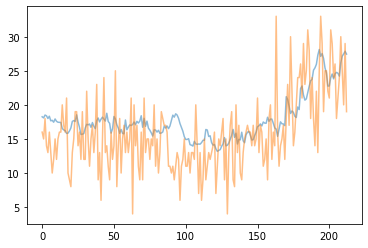

In [293]:
plt.plot(np.double(pred[:, -1, -1]).flatten(), alpha = .5)
plt.plot(np.double(Y_test[:, -1, -1]).flatten(), alpha = .5)

In [277]:
def last_time_step_mse_total(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1, -1], Y_pred[:, -1, -1])
last_time_step_mse_total(Y_test, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=19.642014>

In [27]:
pred = model.predict(X_valid)

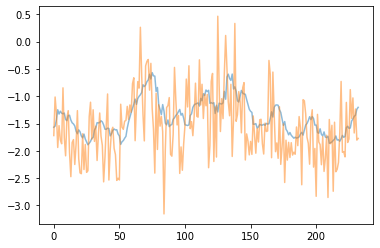

In [28]:
plt.plot(np.double(pred[:, -1]).flatten(), alpha = .5)
plt.plot(np.double(Y_valid[:, -1]).flatten(), alpha = .5)

In [26]:
pred.shape

(233, 14)

# shap value

In [27]:
import shap

/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def f(X):
    return model.predict(X)[:, -1]

In [40]:
# explainer = shap.KernelExplainer(f, X_test[:50])

In [29]:
explainer = shap.DeepExplainer(model, X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [30]:
X_test[:50, -1, :].shape

(50, 92)

In [31]:
model.inputs

[<KerasTensor: shape=(None, 14, 92) dtype=float32 (created by layer 'input_1')>]

In [32]:
# https://github.com/slundberg/shap/issues/1226 the nonetype shape problem

In [33]:
shap_values = explainer.shap_values(X_test)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/shap/explainers/_deep/deep_tf.py:252 grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/eager/backprop.py:1090 gradient  **
        unconnected_gradients=unconnected_gradients)
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/eager/imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/eager/backprop.py:148 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/framework/registry.py:100 lookup
        "%s registry has no entry for: %s" % (self._name, name))

    LookupError: gradient registry has no entry for: shap_BatchToSpaceND


In [46]:
X_test.shape

(219, 14, 92)

In [83]:
input_data_shiftedy.shape

(2313, 15, 1)